In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import gc 
import regex as re
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
pd.set_option('display.max_colwidth', 500)

In [2]:
df = pd.read_csv('data/train.csv')
df.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,"When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.\nThe floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles...",-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewhat silent, her eyes resting on Dolly with a wistful, uncertain expression. She wanted to give the child the pleasure she craved, but she had hard work to bring herself to the point of overcoming her own objections.\nAt last, however, when the meal was nearly over, she smiled at her little daughter, and said, ""All right, Dolly, you may go.""\n""Oh, mother!"" Dolly cried, overwhelmed with sudden delight. ""Really?\nOh, I am so glad! Are you sure you're...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as quickly as it came, and two days after their sleigh ride there was scarcely a vestige of white on the ground. Tennis was again possible and a great game was in progress on the court at Pine Laurel. Patty and Roger were playing against Elise and Sam Blaney, and the pairs were well matched.\nBut the long-contested victory finally went against Patty, and she laughingly accepted defeat.\n""Only because Patty's not quite back on her game yet,"" Roger def...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,"And outside before the palace a great garden was walled round, filled full of stately fruit-trees, gray olives and sweet figs, and pomegranates, pears, and apples, which bore the whole year round. For the rich south-west wind fed them, till pear grew ripe on pear, fig on fig, and grape on grape, all the winter and the spring. And at the farther end gay flower-beds bloomed through all seasons of the year; and two fair fountains rose, and ran, one through the garden grounds, and one beneath th...",-1.054013,0.450007
4,37c1b32fb,NaN,NaN,"Once upon a time there were Three Bears who lived together in a house of their own in a wood. One of them was a Little, Small, Wee Bear; and one was a Middle-sized Bear, and the other was a Great, Huge Bear. They had each a pot for their porridge; a little pot for the Little, Small, Wee Bear; and a middle-sized pot for the Middle Bear; and a great pot for the Great, Huge Bear. And they had each a chair to sit in; a little chair for the Little, Small, Wee Bear; and a middle-sized chair for th...",0.247197,0.510845


### Columns
id - unique ID for excerpt <br>
url_legal - URL of source - this is blank in the test set.<br>
license - license of source material - this is blank in the test set.<br>
excerpt - text to predict reading ease of<br>
target - reading ease (LOWER THE HARDER READABILITY)<br>
standard_error - measure of spread of scores among multiple raters for each excerpt. Not included for test data.<br>

### Check Nulls

In [16]:
nan_count = df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False)
print("ALL NANS\n"+str(nan_count))

ALL NANS
url_legal    2004
license      2004
dtype: int64


### Does standard error matter? Doesn't appear so at least in my opinion

In [6]:
print(df.standard_error.idxmax())
df.standard_error.idxmin()

2235


106

In [18]:
#hide_input
print("Max standard deviation excerpt vs Min standard deviation excerpt")
print(df.excerpt[2235])
print(df.target[2235])
print(df.excerpt[106])
print(df.target[106])

On the basis of the preceding comparisons some writers attempt to trace tentatively the history of the flood tradition current among the peoples of southwestern Asia. A fragment of the Babylonian flood story, coming from at least as early as 2000 B.C., has recently been discovered. The probability is that the tradition goes back to the earliest beginnings of Babylonian history. The setting of the Biblical accounts of the flood is also the Tigris-Euphrates valley rather than Palestine. The description of the construction of the ark in Genesis 6:14-16 is not only closely parallel to that found in the Babylonian account, but the method—the smearing of the ark within and without with bitumen—is peculiar to the Tigris-Euphrates valley. Many scholars believe, therefore, that Babylonia was the original home of the Biblical flood story.
Its exact origin, however, is not so certain. Many of its details were doubtless suggested by the annual floods and fogs which inundate that famous valley and 

In [103]:
## Searches matching substrings
for i in range(len(df.excerpt)):
    if re.search('\!', df.excerpt[i]) != None:
        print(i)
        print(re.search('\!', df.excerpt[i]))
        print(df.excerpt[i])

1
<regex.Match object; span=(398, 399), match='!'>
All through dinner time, Mrs. Fayre was somewhat silent, her eyes resting on Dolly with a wistful, uncertain expression. She wanted to give the child the pleasure she craved, but she had hard work to bring herself to the point of overcoming her own objections.
At last, however, when the meal was nearly over, she smiled at her little daughter, and said, "All right, Dolly, you may go."
"Oh, mother!" Dolly cried, overwhelmed with sudden delight. "Really?
Oh, I am so glad! Are you sure you're willing?"
"I've persuaded myself to be willing, against my will," returned Mrs. Fayre, whimsically. "I confess I just hate to have you go, but I can't bear to deprive you of the pleasure trip. And, as you say, it would also keep Dotty at home, and so, altogether, I think I shall have to give in."
"Oh, you angel mother! You blessed lady! How good you are!" And Dolly flew around the table and gave her mother a hug that nearly suffocated her.
2
<regex.Ma

In [3]:
word_count = df['excerpt'].str.split().str.len()
char_count = df['excerpt'].apply(len)
period_count = df['excerpt'].str.split('\.\s').str.len()
question_count = df['excerpt'].str.count('\\?')
exclamation_count = df['excerpt'].str.count('\!')

print("Average number of character: "+str(word_count.mean()))
print("Average number of words: "+str(char_count.mean()))
print("Average number of periods: "+str(period_count.mean()))
print("Average number of question marks: "+str(question_count.mean()))
print("Average number of exclamation marks: "+str(exclamation_count.mean()))

Average number of character: 172.98200423429782
Average number of words: 971.7328863796754
Average number of periods: 8.63514467184192
Average number of question marks: 0.35568101623147497
Average number of exclamation marks: 0.4573041637261821


In [4]:
## Add word_count and char_count as feature
df['word_count'] = word_count
df['char_count'] = char_count
df['period_count'] = period_count
df['ques_count'] = question_count
df['excl_count'] = exclamation_count
df['sent_count'] = df['ques_count'] + df['period_count'] + df['excl_count']

In [122]:
df.head()

,excerpt,target,word_count,char_count,period_count,ques_count,excl_count,sent_count
0,"When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.\nThe floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles...",0.619195,179,992,11,0,0,11
1,"All through dinner time, Mrs. Fayre was somewhat silent, her eyes resting on Dolly with a wistful, uncertain expression. She wanted to give the child the pleasure she craved, but she had hard work to bring herself to the point of overcoming her own objections.\nAt last, however, when the meal was nearly over, she smiled at her little daughter, and said, ""All right, Dolly, you may go.""\n""Oh, mother!"" Dolly cried, overwhelmed with sudden delight. ""Really?\nOh, I am so glad! Are you sure you're...",0.623814,169,937,8,2,5,15
2,"As Roger had predicted, the snow departed as quickly as it came, and two days after their sleigh ride there was scarcely a vestige of white on the ground. Tennis was again possible and a great game was in progress on the court at Pine Laurel. Patty and Roger were playing against Elise and Sam Blaney, and the pairs were well matched.\nBut the long-contested victory finally went against Patty, and she laughingly accepted defeat.\n""Only because Patty's not quite back on her game yet,"" Roger def...",0.574675,166,908,9,0,1,10
3,"And outside before the palace a great garden was walled round, filled full of stately fruit-trees, gray olives and sweet figs, and pomegranates, pears, and apples, which bore the whole year round. For the rich south-west wind fed them, till pear grew ripe on pear, fig on fig, and grape on grape, all the winter and the spring. And at the farther end gay flower-beds bloomed through all seasons of the year; and two fair fountains rose, and ran, one through the garden grounds, and one beneath th...",0.486715,164,909,5,0,0,5
4,"Once upon a time there were Three Bears who lived together in a house of their own in a wood. One of them was a Little, Small, Wee Bear; and one was a Middle-sized Bear, and the other was a Great, Huge Bear. They had each a pot for their porridge; a little pot for the Little, Small, Wee Bear; and a middle-sized pot for the Middle Bear; and a great pot for the Great, Huge Bear. And they had each a chair to sit in; a little chair for the Little, Small, Wee Bear; and a middle-sized chair for th...",0.728232,147,723,5,0,0,5


<AxesSubplot:xlabel='excerpt'>

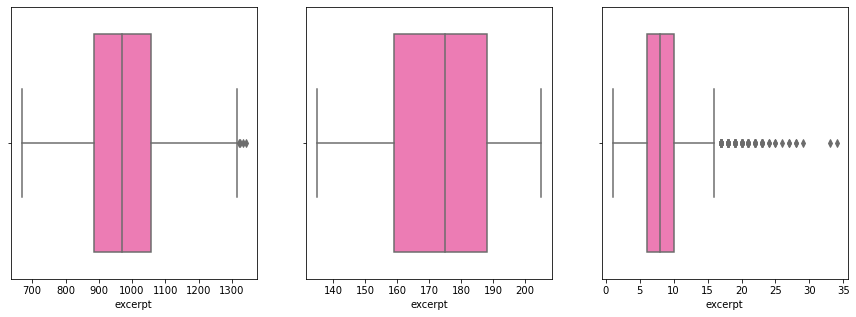

In [123]:
fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(15,5))
sns.boxplot(x=char_count, color='hotpink', ax=ax[0])
sns.boxplot(x=word_count, color='hotpink', ax=ax[1])
sns.boxplot(x=sentence_count, color='hotpink', ax=ax[2])

In [46]:
df.target.describe()

count    2834.000000
mean       -0.959319
std         1.033579
min        -3.676268
25%        -1.690320
50%        -0.912190
75%        -0.202540
max         1.711390
Name: target, dtype: float64

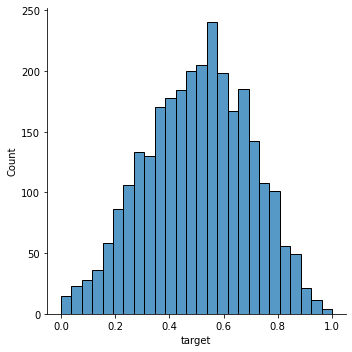

In [17]:
min_max_scaler = preprocessing.MinMaxScaler()
target_scaled = min_max_scaler.fit_transform(pd.DataFrame(df.target))
df.target = target_scaled
sns.displot(df.target)

In [6]:
df = df.drop(['id','url_legal','license','standard_error'], axis=1)

In [127]:
df_sorted = df.sort_values('target')
print("TARGET NEAR 0\n")
print(df_sorted.excerpt.head(5))
print('\nTARGET NEAR 1')
print(df_sorted.excerpt.tail(5))

TARGET NEAR 0

1705    The commutator is peculiar, consisting of only three segments of a copper ring, while in the simplest of other continuous current generators several times that number exist, and frequently 120! segments are to be found. These three segments are made so as to be removable in a moment for cleaning or replacement. They are mounted upon a metal support, and are surrounded on all sides by a free air space, and cannot, therefore, lose their insulated condition. This feature of air insulation is pe...
1128    The Dunwich horror itself came between Lammas and the equinox in 1928, and Dr. Armitage was among those who witnessed its monstrous prologue. He had heard, meanwhile, of Whateley's grotesque trip to Cambridge, and of his frantic efforts to borrow or copy from the Necronomicon at the Widener Library. Those efforts had been in vain, since Armitage had issued warnings of the keenest intensity to all librarians having charge of the dreaded volume. Wilbur had been shock

In [145]:
temp_num = 1000
print(df_sorted[:temp_num]['word_count'].mean() - df_sorted[-temp_num:]['word_count'].mean())
print(df_sorted[:temp_num]['char_count'].mean() - df_sorted[-temp_num:]['char_count'].mean())
print(df_sorted[:temp_num]['period_count'].mean() - df_sorted[-temp_num:]['period_count'].mean())
print(df_sorted[:temp_num]['ques_count'].mean() - df_sorted[-temp_num:]['ques_count'].mean())
print(df_sorted[:temp_num]['excl_count'].mean() - df_sorted[-temp_num:]['excl_count'].mean())
print(df_sorted[:temp_num]['sent_count'].mean() - df_sorted[-temp_num:]['sent_count'].mean())


4.48599999999999
95.577
-2.2589999999999995
-0.43199999999999994
-0.556
-3.2470000000000008


<AxesSubplot:>

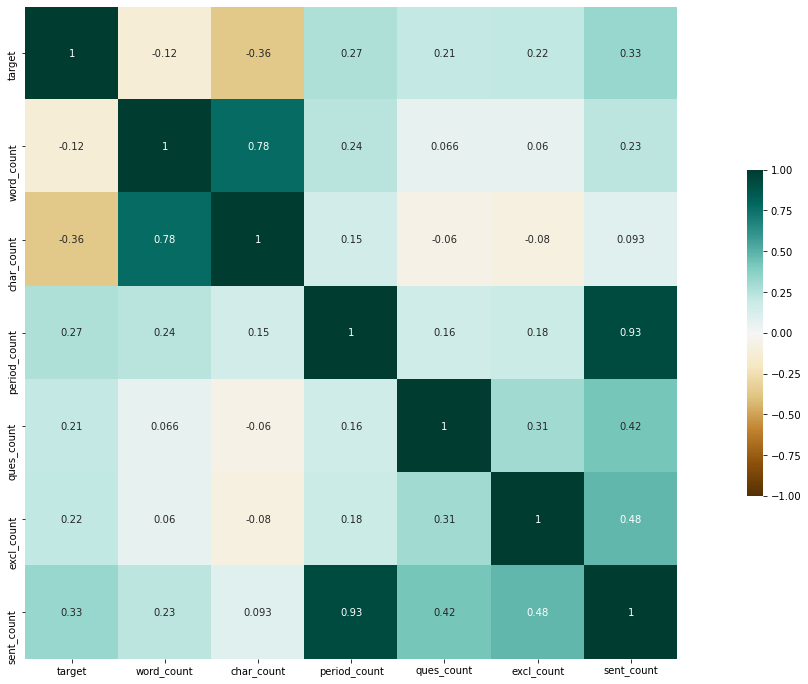

In [161]:
fig, ax = plt.subplots(figsize=(25,12))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_heatmap.corr(), cmap='BrBG',  center=0,vmin=-1, vmax=1, annot=True,
            square=True, cbar_kws={"shrink": .5})

In [155]:
df_heatmap = df_sorted.drop('excerpt',axis=1)
df_heatmap

,target,word_count,char_count,period_count,ques_count,excl_count,sent_count
1705,0.000000,177,1068,7,0,1,8
1128,0.001468,195,1174,9,0,0,9
1754,0.006195,194,1189,6,0,0,6
1752,0.006744,184,1175,7,0,0,7
1720,0.007319,188,1078,8,0,0,8
...,...,...,...,...,...,...,...
1066,0.954762,195,1074,17,1,0,18
1014,0.968499,156,805,16,2,4,22
808,0.976327,192,968,19,0,0,19
981,0.978930,165,896,12,1,1,14


In [162]:
df_sorted.to_csv('data/df_01.csv')

## 06/05/2021

In [3]:
df = pd.read_csv('data/df_01.csv')

In [4]:
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import GridSearchCV
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(df.drop(['excerpt','target'], axis=1), df.target, test_size=0.33, random_state=27)


In [5]:
# #Grid search
# rnd_reg = RandomForestRegressor(n_jobs=-1, random_state=27)
# param_grid = { 
#     'n_estimators': [1000,2000,4000],
#     'max_leaf_nodes': [32, 64],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [4,16,64],
#     'criterion' :['mse', 'mae']
# }
# cv_rnd_reg = GridSearchCV(estimator=rnd_reg, param_grid=param_grid, cv=5)
# cv_rnd_reg.fit(X_train, y_train)

# #Grid search result
# cv_rnd_reg.best_params_

# best param 
# {'criterion': 'mse',
#  'max_depth': 16,
#  'max_features': 'auto',
#  'max_leaf_nodes': 64,
#  'n_estimators': 1000}

rnd_reg = RandomForestRegressor(n_jobs=-1, random_state=27, criterion='mse',max_depth=16,
                                max_features='auto', max_leaf_nodes=64, n_estimators=1000)
rnd_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=16, max_leaf_nodes=64, n_estimators=1000,
                      n_jobs=-1, random_state=27)

Feature: 0, Score: 0.15112
Feature: 1, Score: 0.44862
Feature: 2, Score: 0.04056
Feature: 3, Score: 0.03197
Feature: 4, Score: 0.03833
Feature: 5, Score: 0.28941


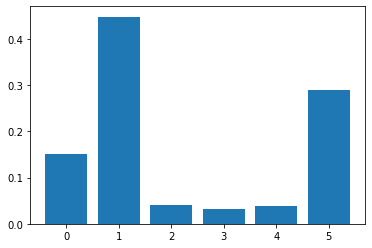

Index(['word_count', 'char_count', 'period_count', 'ques_count', 'excl_count',
       'sent_count'],
      dtype='object')


In [10]:
# get importance
importance = rnd_reg.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()
print(X_train.columns)

In [6]:
y_pred = rnd_reg.predict(X_test)
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Root Mean Squared Error: 0.14858541309210635


## Word tokenization

In [32]:
import spacy
# Load English tokenizer, rtagger, parser and NER
nlp = spacy.load("en_core_web_sm")
doc = nlp(df.excerpt[0])
lemmatizer = nlp.get_pipe("lemmatizer")
processed = lemmatizer(doc)
processed.numerize()

AttributeError: 'spacy.tokens.doc.Doc' object has no attribute 'numerize'

In [24]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
processed

When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.
The floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.
At each end of the room, on the wall, hung a beautiful bear-skin rug.
These rugs were for prizes, one for the girls and one for the boys. And this was the game.
The girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.
This would have been an easy matter, but each traveller was obliged to wear snowshoes.

In [13]:
df

,excerpt,target,word_count,char_count,period_count,ques_count,excl_count,sent_count
0,"When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.\nThe floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.\nAt each end of the room, on the wall, hung a beautiful bear-skin rug.\nThe...",-0.340259,179,992,11,0,0,11
1,"All through dinner time, Mrs. Fayre was somewhat silent, her eyes resting on Dolly with a wistful, uncertain expression. She wanted to give the child the pleasure she craved, but she had hard work to bring herself to the point of overcoming her own objections.\nAt last, however, when the meal was nearly over, she smiled at her little daughter, and said, ""All right, Dolly, you may go.""\n""Oh, mother!"" Dolly cried, overwhelmed with sudden delight. ""Really?\nOh, I am so glad! Are you sure you're willing?""\n""I've persuaded myself to be willing, against my will,"" returned Mrs. Fayre, whimsically...",-0.315372,169,937,8,2,5,15
2,"As Roger had predicted, the snow departed as quickly as it came, and two days after their sleigh ride there was scarcely a vestige of white on the ground. Tennis was again possible and a great game was in progress on the court at Pine Laurel. Patty and Roger were playing against Elise and Sam Blaney, and the pairs were well matched.\nBut the long-contested victory finally went against Patty, and she laughingly accepted defeat.\n""Only because Patty's not quite back on her game yet,"" Roger defended; ""this child has been on the sick list, you know, Sam, and she isn't up to her own mark.""\n""We...",-0.580118,166,908,9,0,1,10
3,"And outside before the palace a great garden was walled round, filled full of stately fruit-trees, gray olives and sweet figs, and pomegranates, pears, and apples, which bore the whole year round. For the rich south-west wind fed them, till pear grew ripe on pear, fig on fig, and grape on grape, all the winter and the spring. And at the farther end gay flower-beds bloomed through all seasons of the year; and two fair fountains rose, and ran, one through the garden grounds, and one beneath the palace gate, to water all the town. Such noble gifts the heavens had given to Alcinous the wise.\n...",-1.054013,164,909,5,0,0,5
4,"Once upon a time there were Three Bears who lived together in a house of their own in a wood. One of them was a Little, Small, Wee Bear; and one was a Middle-sized Bear, and the other was a Great, Huge Bear. They had each a pot for their porridge; a little pot for the Little, Small, Wee Bear; and a middle-sized pot for the Middle Bear; and a great pot for the Great, Huge Bear. And they had each a chair to sit in; a little chair for the Little, Small, Wee Bear; and a middle-sized chair for the Middle Bear; and a great chair for the Great, Huge Bear. And they had each a bed to sleep in; a li...",0.247197,147,723,5,0,0,5
...,...,...,...,...,...,...,...,...
2829,"When you think of dinosaurs and where they lived, what do you picture? Do you see hot, steamy swamps, thick jungles, or sunny plains? Dinosaurs lived in those places, yes. But did you know that some dinosaurs lived in the cold and the darkness near the North and South Poles?\nThis surprised scientists, too. Paleontologists used to believe that dinosaurs lived only in the warmest parts of the world. They thought that dinosaurs could only have lived in places where turtles, crocodiles, and snakes live today. Later, these dinosaur scientists began finding bones in surprising places.\nOne of t...",1.711390,145,901,10,3,0,13
2830,"So what is a solid? Solids are usually hard because their molecules have b

In [ ]:
print(df.excerpt[2])
print(coll_repr(tkn(df.excerpt[2]), 50))

In [ ]:
dls = TextDataLoaders.from_df(df, text_col='excerpt', is_lm=True)

